In [0]:
import re, string 
import pandas as pd 
from time import time
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
# from nltk.corpus import stopwords
import nltk 
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from matplotlib import pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/asharapat/NLP/master/bbc-text.csv')

In [0]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [0]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove a sentence if it is only one word long
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.text.apply(lambda x: clean_text(x)))

In [0]:
df_clean.head()


,text
0,tv future hands viewers home theatre systems p...
1,worldcom boss left books alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...
3,yeading face newcastle fa cup premiership side...
4,ocean twelve raids box office ocean twelve cri...


In [0]:
nlp = spacy.load('en', disable=['ner', 'parser']) 

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['text']), axis=1)

In [0]:
df_clean.head()

,text,text_lemmatize
0,tv future hands viewers home theatre systems p...,tv future hand viewer home theatre system plas...
1,worldcom boss left books alone former worldcom...,worldcom boss leave book alone former worldcom...
2,tigers wary farrell gamble leicester say rushe...,tiger wary farrell gamble leicester say rush m...
3,yeading face newcastle fa cup premiership side...,yeade face newcastle fa cup premiership side n...
4,ocean twelve raids box office ocean twelve cri...,ocean twelve raid box office ocean twelve crim...


In [0]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [0]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

24581

In [0]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say', 'mr', 'year', 'would', 'make', 'also', 'people', 'new', 'one', 'take']

In [0]:
w2v_model = Word2Vec(min_count=200,
                     window=5,
                     size=100,
                     workers=4)

In [0]:
w2v_model.build_vocab(sentences)

In [0]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(980197, 2380445)

In [0]:
w2v_model.init_sims(replace=True)

In [0]:
w2v_model.wv.most_similar(positive=['economy'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('economic', 0.9800892472267151),
 ('rate', 0.9620814919471741),
 ('growth', 0.9395363926887512),
 ('low', 0.9123548269271851),
 ('interest', 0.9012768268585205),
 ('continue', 0.8957304954528809),
 ('rise', 0.8799986839294434),
 ('boost', 0.8623327612876892),
 ('spending', 0.8547176122665405),
 ('figure', 0.848708987236023)]

In [0]:
w2v_model.wv.most_similar(positive=['president'])


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('commission', 0.9283462762832642),
 ('foreign', 0.9111496210098267),
 ('financial', 0.8898757696151733),
 ('agree', 0.8887817859649658),
 ('concern', 0.8555855751037598),
 ('statement', 0.8464854955673218),
 ('raise', 0.8408710360527039),
 ('trade', 0.83677077293396),
 ('official', 0.8335548043251038),
 ('investment', 0.8287304639816284)]

In [0]:
w2v_model.wv.similarity('company', 'business')


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.8258894

In [0]:
def tsne_plot(model, wordToFind):
    "Create TSNE model and plot it"
    labels = []
    tokens = []
    
    tokens.append(model[wordToFind])
    labels.append(wordToFind)

    for word, value in model.wv.most_similar(positive=[wordToFind]):
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10))
    plt.scatter(x[0],y[0], c='#ff0000')
    plt.annotate(labels[0],
                     xy=(x[0], y[0]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    for i in range(1, len(x)):
        plt.scatter(x[i],y[i], c='#000000')
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [0]:
w2v_model.wv.vocab


{'able': <gensim.models.keyedvectors.Vocab at 0x7f478a69c6d8>,
 'access': <gensim.models.keyedvectors.Vocab at 0x7f478a6a3940>,
 'accord': <gensim.models.keyedvectors.Vocab at 0x7f478ef11550>,
 'account': <gensim.models.keyedvectors.Vocab at 0x7f478a6a3a20>,
 'across': <gensim.models.keyedvectors.Vocab at 0x7f478a6992e8>,
 'act': <gensim.models.keyedvectors.Vocab at 0x7f478a699f28>,
 'action': <gensim.models.keyedvectors.Vocab at 0x7f478a6a3da0>,
 'actor': <gensim.models.keyedvectors.Vocab at 0x7f478a6a3400>,
 'add': <gensim.models.keyedvectors.Vocab at 0x7f478a70dd68>,
 'age': <gensim.models.keyedvectors.Vocab at 0x7f478a6a0c18>,
 'ago': <gensim.models.keyedvectors.Vocab at 0x7f478a6990f0>,
 'agree': <gensim.models.keyedvectors.Vocab at 0x7f478a6a0908>,
 'ahead': <gensim.models.keyedvectors.Vocab at 0x7f478a6a3b70>,
 'aid': <gensim.models.keyedvectors.Vocab at 0x7f478a6a30f0>,
 'aim': <gensim.models.keyedvectors.Vocab at 0x7f478a6a60f0>,
 'album': <gensim.models.keyedvectors.Vocab at 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


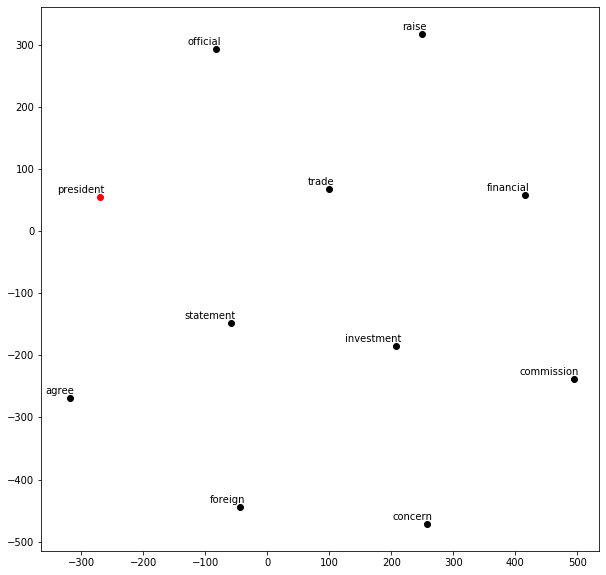

In [0]:
tsne_plot(w2v_model, 'president')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


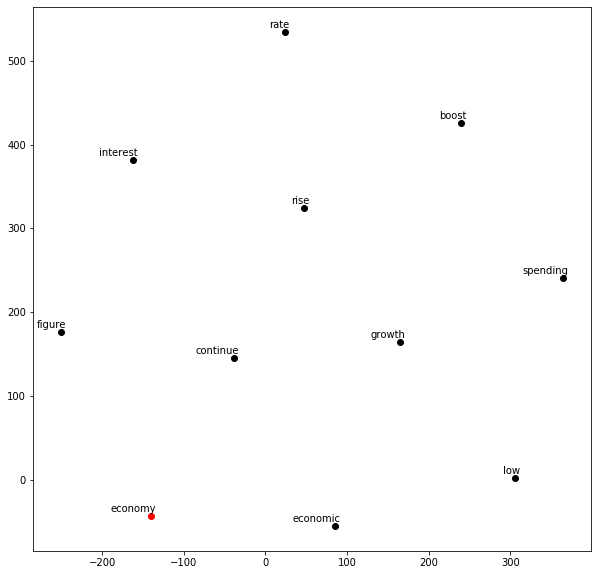

In [0]:
tsne_plot(w2v_model, 'economy')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


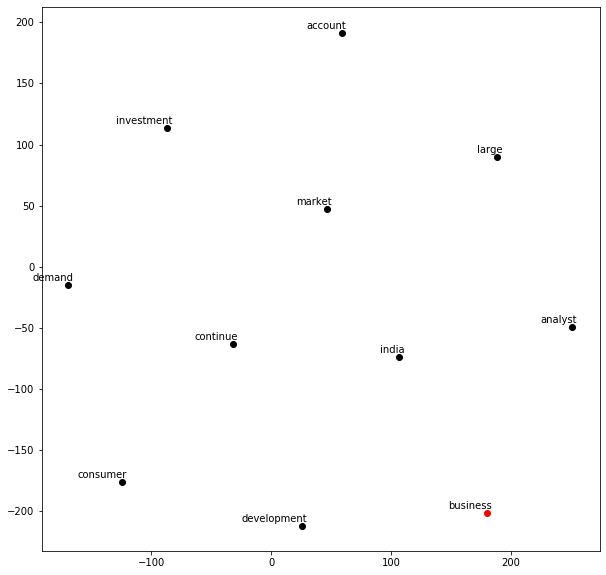

In [0]:
tsne_plot(w2v_model, 'business')
